### **Capstone - Group 2 - CV 1 - Pneumonia Detection Project**

##### Group Members:
1.	Malcolm Nicholas Monserrate
2.	Minatchi S
3.	Navin Kumar Patro
4.	Shiva Chari
5.	Soumya Ranjan Behera
6.	Sunidhi Dixit


### **Context**

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


###  **Milestone 1 – Pneumonia Classification**

This milestone focuses on classifying whether an X-ray indicates **Lung Opacity**, **Normal**, and **No Lung Opacity / Not Normal**.

| Step  | Task                                                   | Description                                                                                                |
| ----- | ------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------- |
| **1** | **Import the data**                                    | Load all required libraries and read input files: `labels.csv`, `class_info.csv`, `sample_submission.csv`. |
| **2** | **Map training & testing images to its classes**       | Merge datasets using `patientId`, check column info, visualize head & tail.                                |
| **3** | **Map training & testing images to its annotations**   | Extract bounding boxes from DICOM metadata and assign labels `Lung Opacity`, `Normal`, and `No Lung Opacity / Not Normal`.                              |
| **4** | **Preprocessing & visualization of different classes** | Check class distribution, univariate plots, check duplicates, missing data.                                |
| **5** | **Display images with bounding box**                   | Render DICOMs using `pydicom`, validate bounding boxes for Pneumonia class.                                |
| **6** | **Design, train and test basic CNN models**            | Build grayscale CNN (224×224), train & evaluate with early stopping, visualize loss/accuracy/metrics.      |
| **7** | **Interim Report (Milestone 1 Submission)**            | Document insights, model architecture, confusion matrix, and export the notebook.                          |

---

###  **Milestone 2 – Pneumonia Localization (Bounding Box Detection)**

This milestone focuses on localizing the actual **Pneumonia region using object detection**.

| Step  | Task                                               | Description                                                                                   |
| ----- | -------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **1** | **Fine-tune trained CNN model for classification** | Apply class rebalancing, threshold tuning, and data augmentation.                             |
| **2** | **Apply Transfer Learning model (Optional)**       | Use pretrained networks like MobileNet, VGG, or DenseNet.                                        |
| **3** | **Design, train and test RCNN & hybrid models**    | Use models like Faster-RCNN or YOLO to detect bounding boxes for Pneumonia regions.           |
| **4** | **Pickle the model for future prediction**         | Serialize trained classification + detection model using `pickle` or `torch.save`.            |
| **5** | **Final Report (Milestone 2 Submission)**          | Compile all outputs, visualizations, evaluation results, and submit polished notebook/report. |



## **Data Description:** 
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### **Dataset Overview:**

* Images are provided in **DICOM (`.dcm`)** format and include metadata along with pixel data.
* Associated `.csv` files provide:

  * Binary labels (pneumonia or not)
  * Bounding box coordinates (for pneumonia-positive cases)
  * Detailed class categorization: `Lung Opacity`, `Normal`, and `No Lung Opacity / Not Normal`

### **Data Fields**
* patientId _- A patientId. Each patientId corresponds to a unique image.
* x_ - the upper-left x coordinate of the bounding box.
* y_ - the upper-left y coordinate of the bounding box.
* width_ - the width of the bounding box.
* height_ - the height of the bounding box.
* Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.



## **Milestone - 1**

### **Import the Libraries & Data**

In [1]:
# include all the imports here
import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pydicom
import random
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, GlobalAveragePooling2D, Input, AveragePooling2D)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from functools import lru_cache
from glob import glob
from tensorflow.keras import metrics
from tensorflow.keras.applications import VGG16
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings("ignore")

#### **Loading CSV files**

In [2]:
train_labels_path =  'stage_2_train_labels.csv'
class_info_path = 'stage_2_detailed_class_info.csv'

# Load CSV files
train_labels_df = pd.read_csv(train_labels_path)
class_info_df = pd.read_csv(class_info_path)

# Display first few rows of each DataFrame
print("Train Labels DataFrame (First 5 rows):")
print("-" * 80)
print(train_labels_df.head())
print("\n\nClass Info DataFrame (First 5 rows):")
print("-" * 80)
print(class_info_df.head())


# Basic stats about the datasets
print("\nTrain Labels DataFrame Info:")
print("-" * 80)
print(f"Shape: {train_labels_df.shape}")
print(f"Columns: {train_labels_df.columns.tolist()}")

print("\n\nClass Info DataFrame Info:")
print("-" * 80)
print(f"Shape: {class_info_df.shape}")
print(f"Columns: {class_info_df.columns.tolist()}")


# Check for missing values
print("\nMissing values in Train Labels DataFrame:")
print("-" * 80)
print(train_labels_df.isnull().sum())
print("\n\nMissing values in Class Info DataFrame:")
print("-" * 80)
print(class_info_df.isnull().sum())


# Count unique patients
unique_patients_labels = train_labels_df['patientId'].nunique()
unique_patients_class = class_info_df['patientId'].nunique()
print(f"\n\nNumber of unique patients in Train Labels: {unique_patients_labels}")
print("-" * 80)
print(f"Number of unique patients in Class Info: {unique_patients_class}")
print("-" * 80)

#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', train_labels_df.duplicated().sum())
print("-" * 80)

print('Count of Duplicates: ', class_info_df.duplicated().sum())
print("-" * 80)
df_class_info_clean = class_info_df.drop_duplicates()
print("After dropping duplicates:", df_class_info_clean.shape)


Train Labels DataFrame (First 5 rows):
--------------------------------------------------------------------------------
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Class Info DataFrame (First 5 rows):
--------------------------------------------------------------------------------
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-4

#### **Train Labels DataFrame Observations**

**Shape:** (30227, 6)

**Columns:** ['patientId', 'x', 'y', 'width', 'height', 'Target']

##### **Data Types:**

**patientId:** object (categorical)

**x, y, width, height:** float (numerical — bounding box coordinates)

**Target:** int (binary classification label: 1 indicates pneumonia, 0 indicates no pneumonia)

##### **Missing Values:**

x, y, width, height have 20,672 missing values each.

patientId and Target have no missing values.

This suggests:

- Only 9,555 images (30227 - 20672) have bounding box annotations.

- Remaining entries without bounding box values (i.e., NaNs) correspond to Target = 0 (no pneumonia).

##### **Notes:**

Each row may represent one bounding box. So a single patient/image may have multiple rows (bounding boxes).

Target = 1 rows typically have bounding boxes; Target = 0 rows do not.

#### **Class Info DataFrame Observations**

**Shape:** (30227, 2)

**Columns:** ['patientId', 'class']

##### **Data Types:**

**patientId:** object (categorical)

**class:** object (categorical classification label)

##### **Class Categories:**

From the sample:

- "No Lung Opacity / Not Normal"

- "Normal"

- "Lung Opacity"

##### **Duplicates:**

3543 duplicate rows were present → Dropped to leave 26684 unique patients.

##### **Cross-Dataset Observations**

After removing duplicates, both DataFrames have 26684 unique patientIds, confirming they refer to the same set of patients.

Train Labels may have multiple entries per patient due to multiple bounding boxes, explaining the row count mismatch.

### **Map Training and Testing Images to Their Classes**

#### Merge the cleaned train_labels and class_info dataframes based on patientId.

In [3]:
# Merge train_labels with class_info to have labels and bounding boxes together
train_data_merged = pd.merge(train_labels_df, df_class_info_clean, on='patientId', how='left')

##### Shape and first few rows of the dataset

In [4]:
# Check merged data
print("Merged DataFrame shape:", train_data_merged.shape)
print(train_data_merged.head())

Merged DataFrame shape: (30227, 7)
                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


##### Statistical Summary of the Dataset

In [5]:
train_data_merged.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Missing Values

In [29]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0],
              'Percentage':(train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0]/train_data_merged.shape[0])*100})

,Count,Percentage
x,20672,68.389188
y,20672,68.389188
width,20672,68.389188
height,20672,68.389188


#### Inspect the distribution of class labels


Class distribution:
 class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


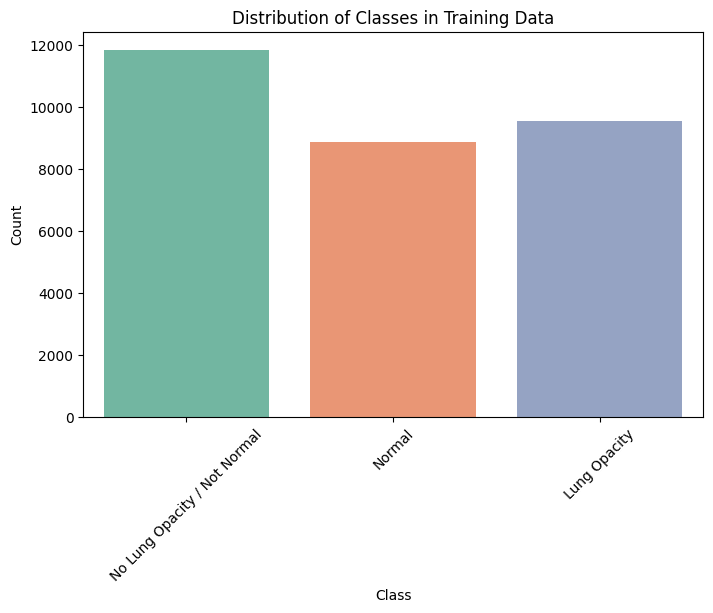

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution count
class_distribution = train_data_merged['class'].value_counts()
print("\nClass distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='Set2', hue='class')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


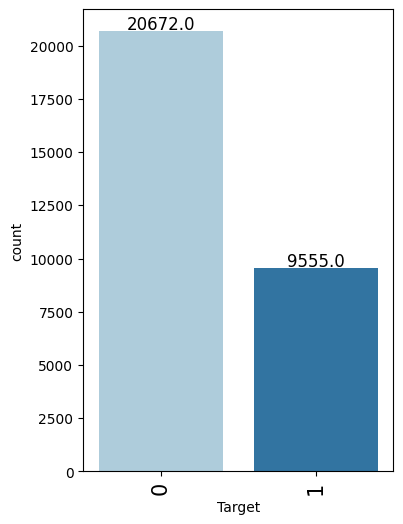

In [ ]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

labeled_barplot(train_data_merged, "Target")

### **Map Training Images to Their Annotations**

#### Map patient IDs to their bounding boxes

In [25]:
# Group annotations by patientId clearly
annotations_grouped = train_data_merged.groupby('patientId')

# Example: Display annotations for a specific patient clearly
sample_patient = train_data_merged[train_data_merged['Target'] == 1]['patientId'].iloc[0]

print(f"\nBounding Boxes for patientId '{sample_patient}':")
print(annotations_grouped.get_group(sample_patient))



Bounding Boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
                              patientId      x      y  width  height  Target  \
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

          class  
4  Lung Opacity  
5  Lung Opacity  


#### Create a convenient annotation dictionary

In [26]:
# Create dictionary mapping patientId to list of bounding boxes (coordinates)
bbox_dict = {}

for patientId, group in annotations_grouped:
    bboxes = group[['x', 'y', 'width', 'height', 'Target']].values
    bbox_dict[patientId] = bboxes

# Verify clearly
print(f"Bounding boxes for patientId '{sample_patient}':")
print(bbox_dict[sample_patient])


Bounding boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
[[264. 152. 213. 379.   1.]
 [562. 152. 256. 453.   1.]]


#### Summary of Bounding Box Data

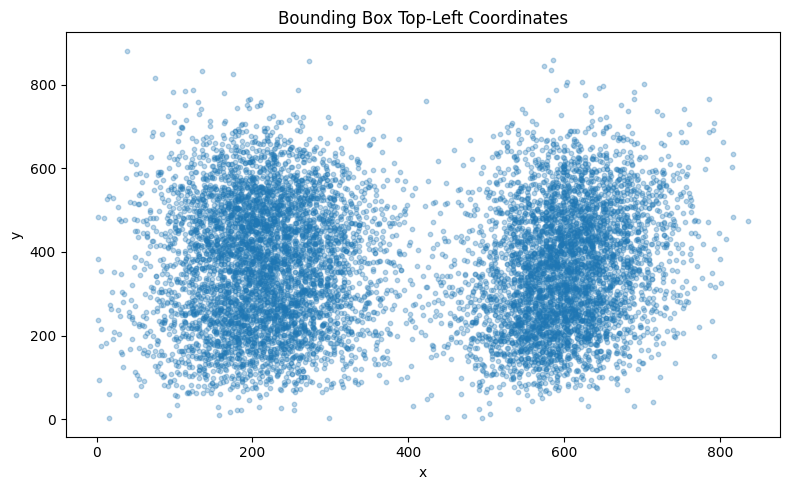

In [29]:
# Bounding boxes co-ordinates
plt.figure(figsize=(8, 5))
pneumonia_boxes = train_data_merged[train_data_merged['Target'] == 1]
plt.scatter(pneumonia_boxes['x'], pneumonia_boxes['y'], alpha=0.3, s=10)
plt.title("Bounding Box Top-Left Coordinates")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### Step 4: Preprocessing and Visualization of Different Classes

In [5]:
# Function to load and preprocess DICOM image
def load_dicom_image(patient_id, img_size=(224, 224)):
    """
    Load and preprocess a DICOM image for a given patient ID

    Parameters:
    - patient_id: ID of the patient
    - img_size: Tuple of (height, width) for resizing

    Returns:
    - Preprocessed image as numpy array
    """
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    # Convert to numpy array
    image = dicom.pixel_array

    # Normalize pixel values to be between 0 and 1
    image = image / np.max(image)

    # Convert to grayscale if necessary
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    image = cv2.resize(image, img_size[::-1])

    # Expand dimensions for CNN input (add channel dimension)
    image = np.expand_dims(image, axis=-1)

    return image

In [35]:
# Sample a few images from each class for visualization
def sample_patients_from_class(class_name, n=4):
    """Sample n patient IDs from a given class"""
    return random.sample(list(train_data_merged[train_data_merged['class'] == class_name]['patientId']), n)

# Sample patient IDs from each class
normal_patients = sample_patients_from_class('Normal',3)
opacity_patients = sample_patients_from_class('Lung Opacity',3)
not_normal_patients = sample_patients_from_class('No Lung Opacity / Not Normal',3)

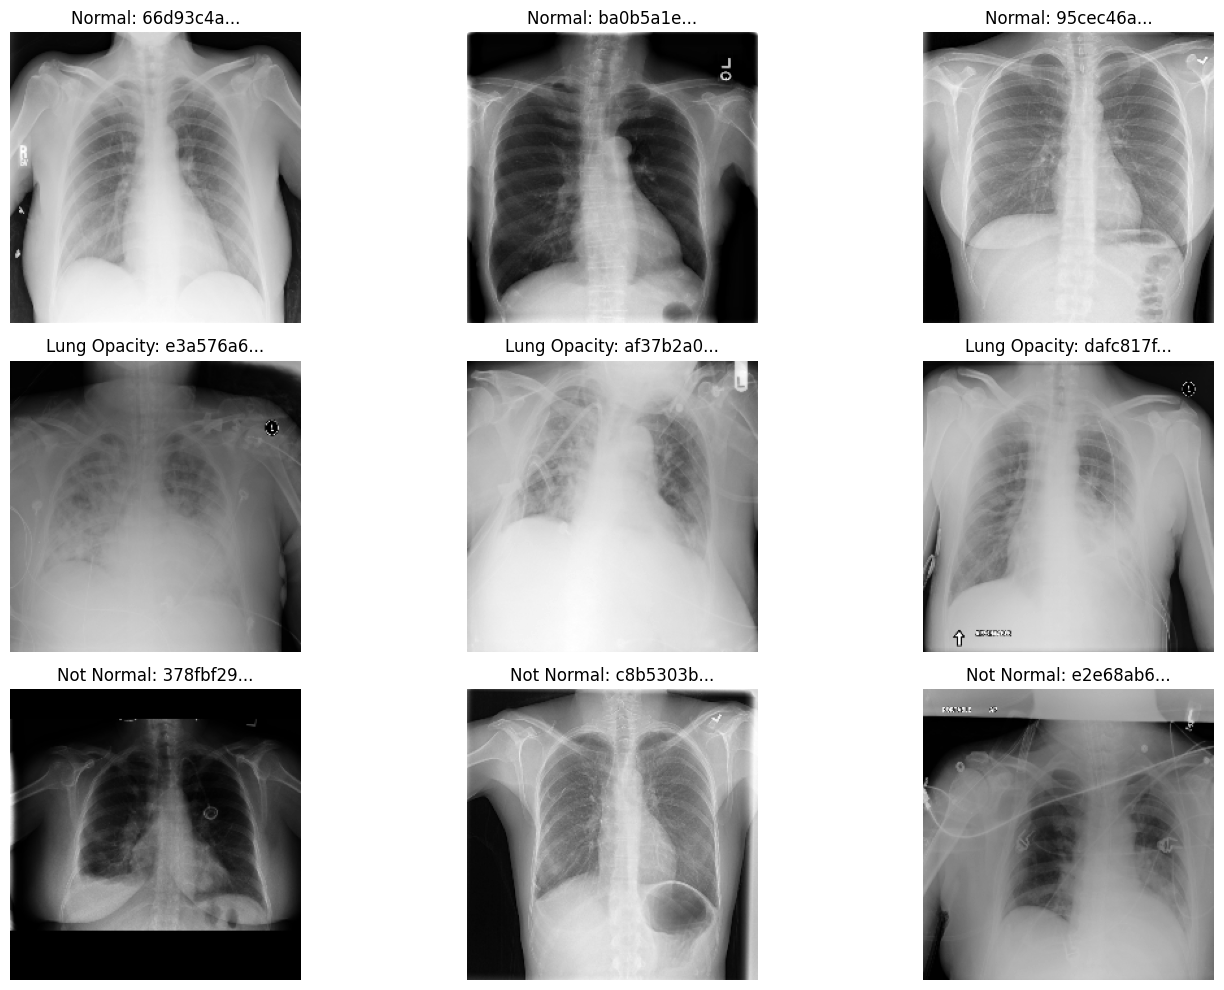

In [38]:
# Plot sample images from each class
plt.figure(figsize=(15, 10))

# Plot Normal images
for i, patient_id in enumerate(normal_patients):
    plt.subplot(3, 3, i+1)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Normal: {patient_id[:8]}...")
    plt.axis('off')

# Plot Lung Opacity images
for i, patient_id in enumerate(opacity_patients):
    plt.subplot(3, 3, i+4)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Lung Opacity: {patient_id[:8]}...")
    plt.axis('off')

# Plot Not Normal No Lung Opacity images
for i, patient_id in enumerate(not_normal_patients):
    plt.subplot(3, 3, i+7)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Not Normal: {patient_id[:8]}...")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Function to load DICOM image with original size
def load_original_dicom(patient_id):
    """Load DICOM image without resizing"""
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    image = dicom.pixel_array
    image = image / np.max(image)
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [40]:
# Function to draw bounding boxes on image
def draw_boxes(image, boxes):
    """Draw bounding boxes on the image"""

    # Ensure image is in uint8 format (0-255)
    if image.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # Convert grayscale image to RGB for colored boxes
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for box in boxes:
        x, y = int(box['x']), int(box['y'])
        w, h = int(box['width']), int(box['height'])
        image_color = cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image_color

In [48]:
# Create a mapping of patient IDs to their respective bounding boxes
patient_boxes = {}
for index, row in train_data_merged.iterrows():
    patient_id = row['patientId']
    target = row['Target']

    if target == 1:  # Only consider rows with Target=1 (has bounding box)
        if patient_id not in patient_boxes:
            patient_boxes[patient_id] = []

        # Add bounding box coordinates
        patient_boxes[patient_id].append({
            'x': row['x'],
            'y': row['y'],
            'width': row['width'],
            'height': row['height']
        })
        
# Sample a few patients with Lung Opacity (which have bounding boxes)
opacity_patients = sample_patients_from_class('Lung Opacity')
opacity_with_boxes = [pid for pid in opacity_patients if pid in patient_boxes]

if not opacity_with_boxes:
    opacity_with_boxes = list(set(patient_boxes.keys()) &
                             set(train_data_merged[train_data_merged['class'] == 'Lung Opacity']['patientId']))[:4]


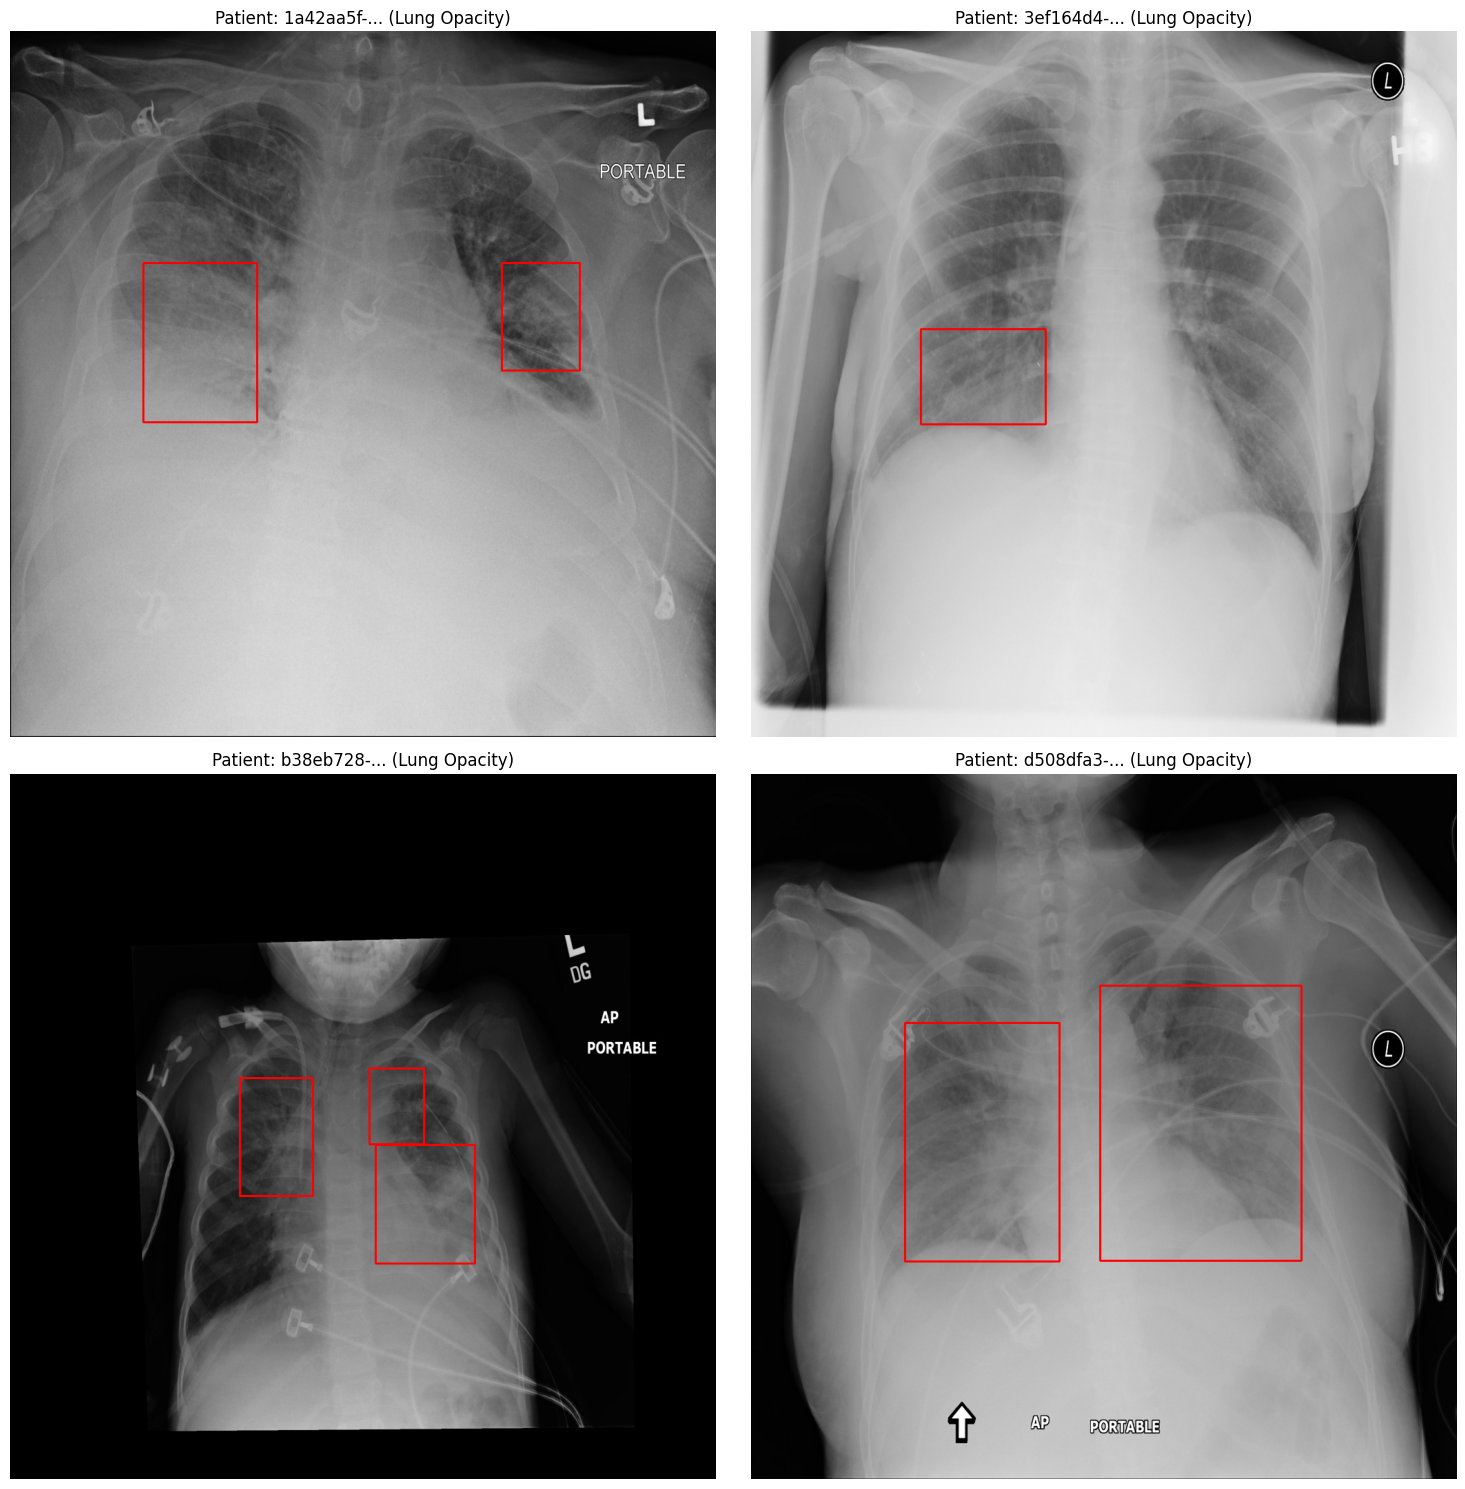

In [49]:
# Plot images with bounding boxes
plt.figure(figsize=(15, 15))

for i, patient_id in enumerate(opacity_with_boxes[:4]):
    try:
        plt.subplot(2, 2, i + 1)
        img = load_original_dicom(patient_id)

        if img is None:
            print(f"[Warning] Image for patient {patient_id} is None.")
            continue

        if patient_id in patient_boxes:
            img_with_boxes = draw_boxes(img, patient_boxes[patient_id])
            plt.imshow(img_with_boxes, cmap='gray')
        else:
            plt.imshow(img, cmap='gray')

        plt.title(f"Patient: {patient_id[:9]}... (Lung Opacity)")
        plt.axis('off')

    except Exception as e:
        print(f"[Error] Failed on patient {patient_id}: {e}")

plt.tight_layout()
plt.show()


#### **Inspect distribution of bounding box dimensions**

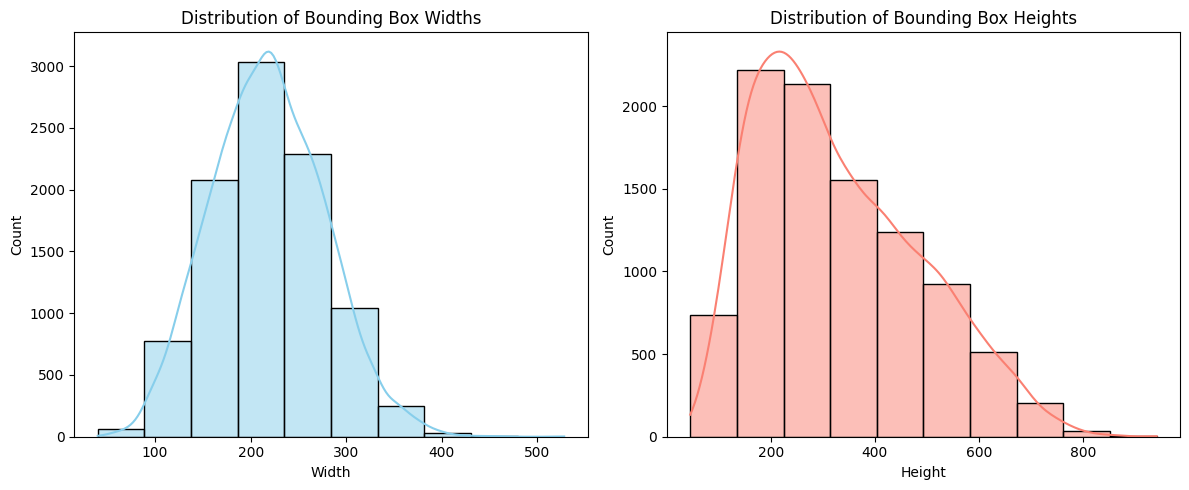

In [44]:
# Visualize distribution of bounding box dimensions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(train_data_merged['width'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')

plt.subplot(1,2,2)
sns.histplot(train_data_merged['height'], bins=10, kde=True, color='salmon')
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')

plt.tight_layout()
plt.show()


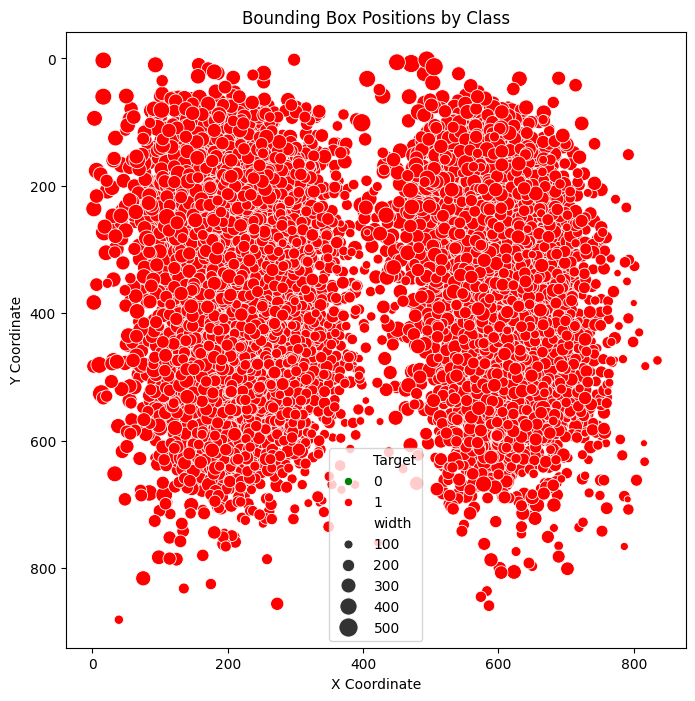

In [45]:
# Create a scatter plot of bounding box positions
plt.figure(figsize=(8,8))
sns.scatterplot(
    x='x', y='y',
    hue='Target',
    size='width', sizes=(20, 200),
    data=train_data_merged, palette=['green', 'red']
)
plt.title('Bounding Box Positions by Class')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates
plt.show()

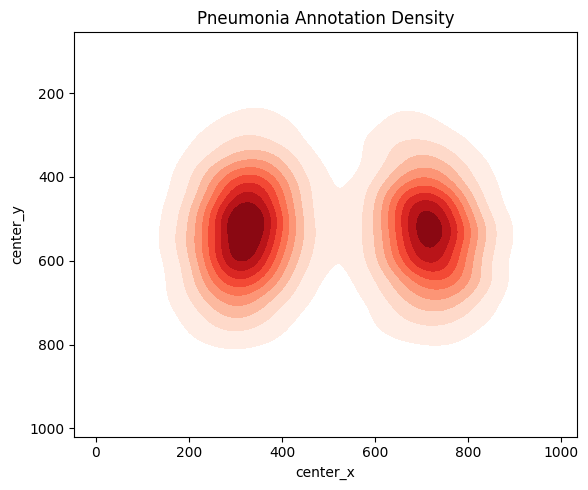

In [ ]:
# Calculate centers of bounding boxes
train_data_merged['center_x'] = train_data_merged['x'] + train_data_merged['width']/2
train_data_merged['center_y'] = train_data_merged['y'] + train_data_merged['height']/2

# Create separate DataFrames for each class
pneumonia_df = train_data_merged[train_data_merged['Target'] == 1]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.kdeplot(x=pneumonia_df['center_x'], y=pneumonia_df['center_y'],
            cmap='Reds', fill=True)
plt.title('Pneumonia Annotation Density')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### **Design, Train, and Test Basic CNN Models**

In [31]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to prevent TensorFlow from consuming all memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs available and configured:", len(gpus))
    except RuntimeError as e:
        print("Error setting up GPU:", e)
else:
    print("Using CPU")


Using CPU


In [6]:
# Parameters
img_size = (224, 224)
input_dir = 'stage_2_train_images/stage_2_train_images'
output_dir = 'preprocessed_images'
num_classes = 3
batch_size = 32

In [7]:
def preprocess_dicom_images_from_folder(input_dir, output_dir):
    """
    Reads all .dcm files from a directory and saves them as .npy files.
    Files are located inside a folder like: input_dir/stage_2_train_images/
    """
    os.makedirs(output_dir, exist_ok=True)

    # Walk through the directory to find .dcm files
    for root, _, files in os.walk(input_dir):
        for file_name in files:
            if file_name.endswith('.dcm'):
                dicom_path = os.path.join(root, file_name)
                try:
                    dicom = pydicom.dcmread(dicom_path, force=True)
                    image = dicom.pixel_array.astype(np.float32)

                    # Normalize
                    image /= np.max(image)

                    # Convert to grayscale if needed
                    if image.ndim > 2:
                        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                    # Resize
                    image = cv2.resize(image, img_size[::-1])
                    image = np.expand_dims(image, axis=-1)

                    # Save with .npy extension
                    npy_name = file_name.replace('.dcm', '.npy')
                    np.save(os.path.join(output_dir, npy_name), image)

                except Exception as e:
                    print(f"[WARN] Skipping {dicom_path}: {e}")

In [70]:
preprocess_dicom_images_from_folder(input_dir, output_dir)

In [8]:
# Load preprocessed data as tf.data.Dataset
def load_dataset_from_dataframe(df, img_dir, batch_size, num_classes):
    filepaths = [os.path.join(img_dir, f"{pid}.npy") for pid in df['patientId']]
    labels = df['class_encoded'].values

    def load_npy_and_label(path, label):
        image = tf.numpy_function(np.load, [path], tf.float32)
        image.set_shape([img_size[0], img_size[1], 1])
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_npy_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
label_encoder = LabelEncoder()
train_data_merged['class_encoded'] = label_encoder.fit_transform(train_data_merged['class'])

In [10]:
# Train / Val split
train_df, val_df = train_test_split(train_data_merged, test_size=0.2, stratify=train_data_merged['class_encoded'], random_state=42)

In [11]:
train_ds = load_dataset_from_dataframe(train_df, output_dir, batch_size, num_classes)
val_ds = load_dataset_from_dataframe(val_df, output_dir, batch_size, num_classes)

In [40]:
# Model Builder Class
class ModelBuilder:
    def __init__(self, input_shape, num_classes=3):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_basic_cnn(self):
        return models.Sequential([
            layers.Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
    
    def build_deeper_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Dropout(0.1),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Dropout(0.2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Dropout(0.3),
            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_lenet5(self):
        model = Sequential([
            Input(shape=self.input_shape),
            Conv2D(6, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Conv2D(16, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(120, activation='tanh'),
            Dense(84, activation='tanh'),
            Dense(self.num_classes, activation='softmax')
        ])
        return model
        
    def build_mobilenetv2(self):
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        inputs = Input(shape=(224, 224, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model


In [12]:
def replicate_grayscale_channels(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert [H,W,1] to [H,W,3]
    return image, label

In [15]:
# callback method
def setup_callbacks(model_name='pneumonia_model_best'):
    """Setup optimized training callbacks"""
    return [
        callbacks.ModelCheckpoint(
            f'{model_name}.keras',
            save_best_only=True,
        ),
        callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            patience=2
        ),
        callbacks.TerminateOnNaN()
    ]

In [19]:
def train_and_evaluate(model_type, train_ds, val_ds, input_shape, num_classes, epochs=10):
    builder = ModelBuilder(input_shape, num_classes)
    
    if model_type == 'BasicCNN':
        model = builder.build_basic_cnn()
    elif model_type == 'DeeperCNN':
        model = builder.build_deeper_cnn()
    elif model_type == 'MobileNetV2':
        model = builder.build_mobilenetv2()
        
        # Convert grayscale to 3-channel RGB for MobileNetV2
        train_ds = train_ds.map(replicate_grayscale_channels, num_parallel_calls=tf.data.AUTOTUNE)
        val_ds = val_ds.map(replicate_grayscale_channels, num_parallel_calls=tf.data.AUTOTUNE)
        
    elif model_type == 'LeNet5':
        model = builder.build_lenet5()
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=setup_callbacks(model_name=f"{model_type}_best_model"), verbose=1)
    return model, history

In [13]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_model(model, val_ds, label_encoder):
    y_true, y_pred = [], []
    for batch_x, batch_y in val_ds:
        preds = model.predict(batch_x, verbose=0)
        y_true.extend(np.argmax(batch_y.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_true_labels = label_encoder.inverse_transform(y_true)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    class_names = label_encoder.classes_

    print("\nClassification Report:")
    print("=" * 80)
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4))

    # Plot confusion matrix
    print("\nConfusion Matrix")
    print("=" * 80)
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [35]:
# Train model
basic_model, basic_history = train_and_evaluate('BasicCNN', train_ds, val_ds, input_shape=(224, 224, 1), num_classes=3)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,771 (42.61 MB)

 Trainable params: 11,168,771 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 549s 725ms/step - accuracy: 0.5027 - loss: 0.9696 - val_accuracy: 0.5844 - val_loss: 0.8725 - learning_rate: 1.0000e-04
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 540s 713ms/step - accuracy: 0.5782 - loss: 0.8686 - val_accuracy: 0.6188 - val_loss: 0.8184 - learning_rate: 1.0000e-04
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 534s 705ms/step - accuracy: 0.5949 - loss: 0.8442 - val_accuracy: 0.6287 - val_loss: 0.7950 - learning_rate: 1.0000e-04
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 536s 708ms/step - accuracy: 0.6097 - loss: 0.8169 - val_accuracy: 0.6371 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 657s 868ms/step - accuracy: 0.6251 - loss: 0.7948 - val_accuracy: 0.6475 - val_loss: 0.7730 - learning_rate: 1.0000e-04
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 610s 805ms/step - accuracy: 0.6322 - loss: 0.7777 - val_accuracy: 0.6477 - val_loss: 0.7652 - learning_rate: 1.0000e-04
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━

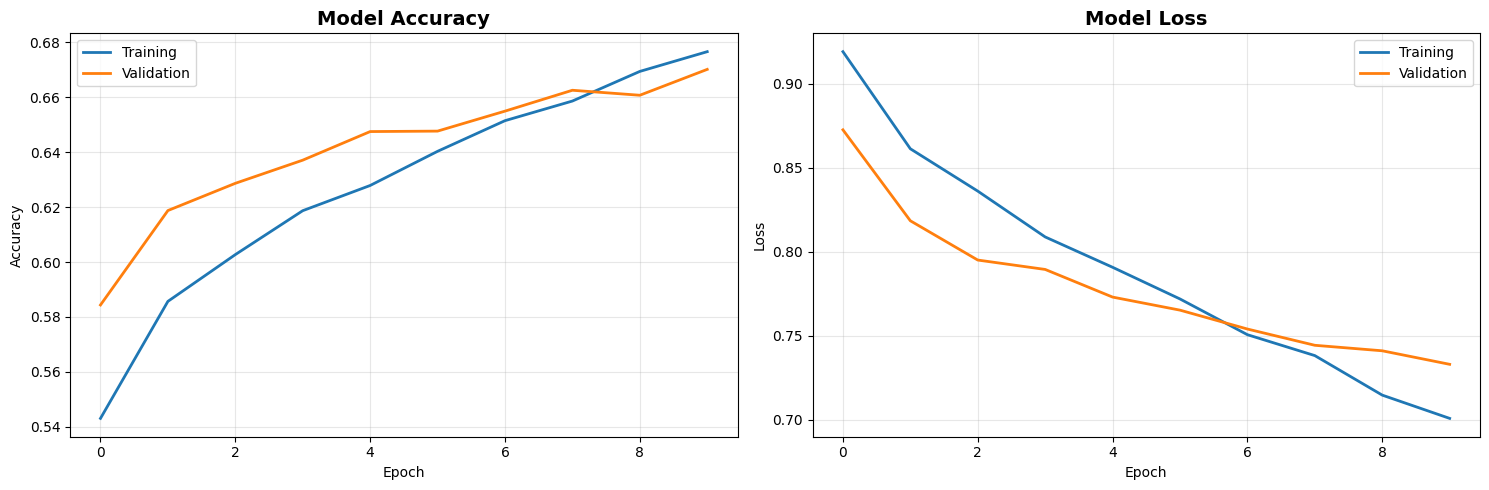

In [36]:
# Plot training history
plot_training_history(basic_history)


Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.7107    0.6620    0.6855      1911
No Lung Opacity / Not Normal     0.6056    0.6025    0.6041      2365
                      Normal     0.7120    0.7695    0.7396      1770

                    accuracy                         0.6702      6046
                   macro avg     0.6761    0.6780    0.6764      6046
                weighted avg     0.6700    0.6702    0.6695      6046


Confusion Matrix


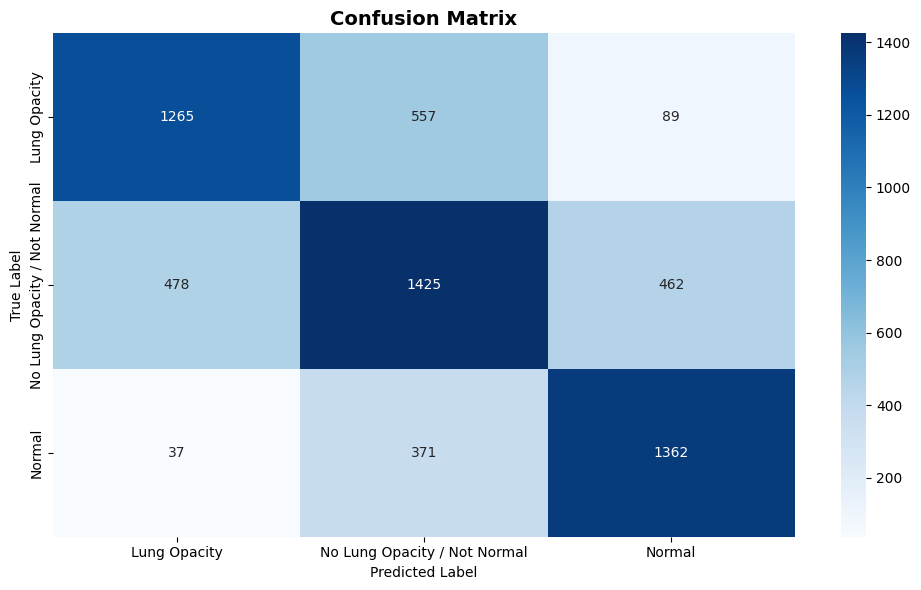

In [37]:
#Evaluating basic model performance
evaluate_model(basic_model, val_ds, label_encoder)

In [41]:
# Train model
mobilenet_model, mobilenet_history = train_and_evaluate('MobileNetV2', train_ds, val_ds, input_shape=(224, 224, 3), num_classes=3)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 359s 469ms/step - accuracy: 0.5918 - loss: 0.8391 - val_accuracy: 0.6674 - val_loss: 0.7227 - learning_rate: 1.0000e-04
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 351s 463ms/step - accuracy: 0.6655 - loss: 0.7210 - val_accuracy: 0.6765 - val_loss: 0.7027 - learning_rate: 1.0000e-04
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 354s 467ms/step - accuracy: 0.6736 - loss: 0.7012 - val_accuracy: 0.6720 - val_loss: 0.7085 - learning_rate: 1.0000e-04
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 337s 445ms/step - accuracy: 0.6828 - loss: 0.6878 - val_accuracy: 0.6770 - val_loss: 0.6974 - learning_rate: 1.0000e-04
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 345s 455ms/step - accuracy: 0.6908 - loss: 0.6744 - val_accuracy: 0.6732 - val_loss: 0.7022 - learning_rate: 1.0000e-04
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 339s 447ms/step - accuracy: 0.7010 - loss: 0.6594 - val_accuracy: 0.6800 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━

In [45]:
# Convert grayscale to 3-channel RGB for MobileNetV2
val_ds = val_ds.map(replicate_grayscale_channels, num_parallel_calls=tf.data.AUTOTUNE)

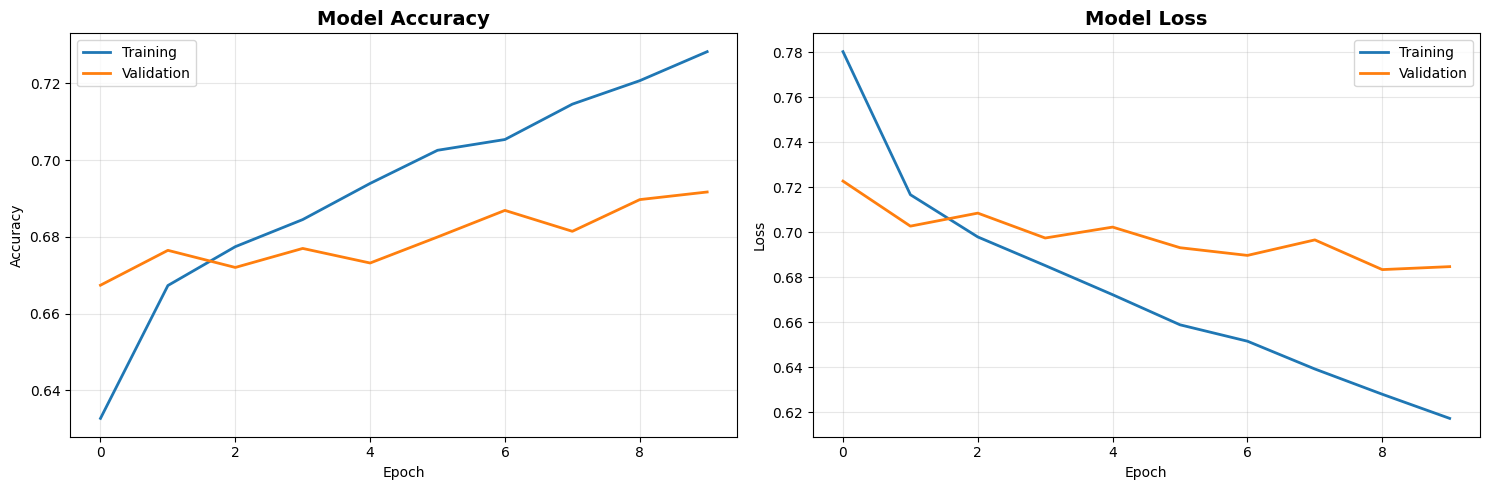

In [46]:
# Plot training history
plot_training_history(mobilenet_history)


Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.7236    0.6358    0.6769      1911
No Lung Opacity / Not Normal     0.6147    0.6516    0.6326      2365
                      Normal     0.7602    0.7989    0.7791      1770

                    accuracy                         0.6897      6046
                   macro avg     0.6995    0.6954    0.6962      6046
                weighted avg     0.6917    0.6897    0.6895      6046


Confusion Matrix


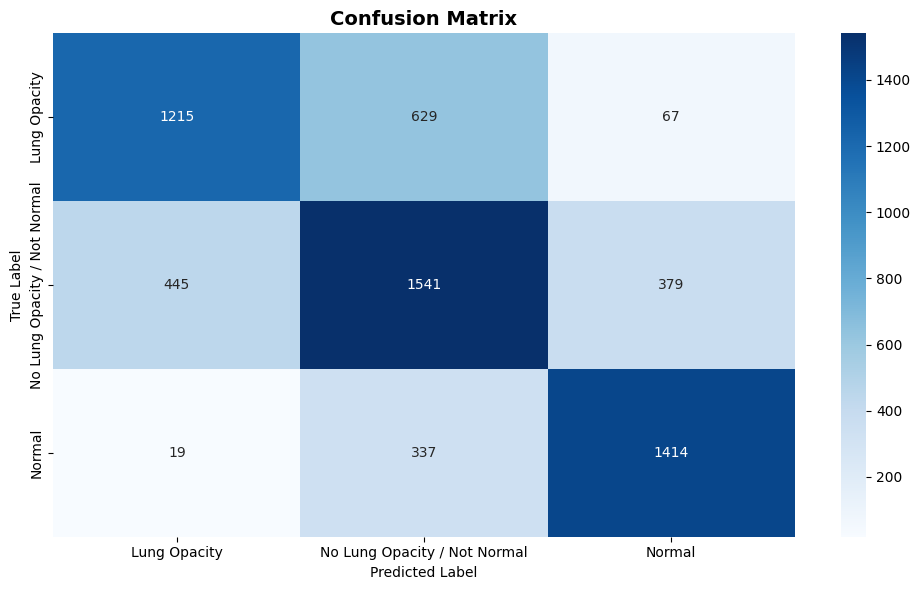

In [47]:
#Evaluating mobilenet model performance
evaluate_model(mobilenet_model, val_ds, label_encoder)

In [48]:
train_ds = load_dataset_from_dataframe(train_df, output_dir, batch_size, num_classes)
val_ds = load_dataset_from_dataframe(val_df, output_dir, batch_size, num_classes)

# Train model
lenet_model, lenet_history = train_and_evaluate('LeNet5', train_ds, val_ds, input_shape=(224, 224, 1), num_classes=3)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 220, 220, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 110, 110, 6)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 53, 53, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 120)            │     5,393,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,406,391 (20.62 MB)

 Trainable params: 5,406,391 (20.62 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 126s 164ms/step - accuracy: 0.4985 - loss: 0.9928 - val_accuracy: 0.5797 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 112s 145ms/step - accuracy: 0.5869 - loss: 0.8581 - val_accuracy: 0.5963 - val_loss: 0.8267 - learning_rate: 1.0000e-04
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 117s 153ms/step - accuracy: 0.6090 - loss: 0.8223 - val_accuracy: 0.6102 - val_loss: 0.8095 - learning_rate: 1.0000e-04
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 112s 146ms/step - accuracy: 0.6269 - loss: 0.7847 - val_accuracy: 0.6166 - val_loss: 0.7997 - learning_rate: 1.0000e-04
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 119s 155ms/step - accuracy: 0.6481 - loss: 0.7488 - val_accuracy: 0.6193 - val_loss: 0.8064 - learning_rate: 1.0000e-04
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 108s 141ms/step - accuracy: 0.6781 - loss: 0.7123 - val_accuracy: 0.6239 - val_loss: 0.7847 - learning_rate: 1.0000e-04
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━

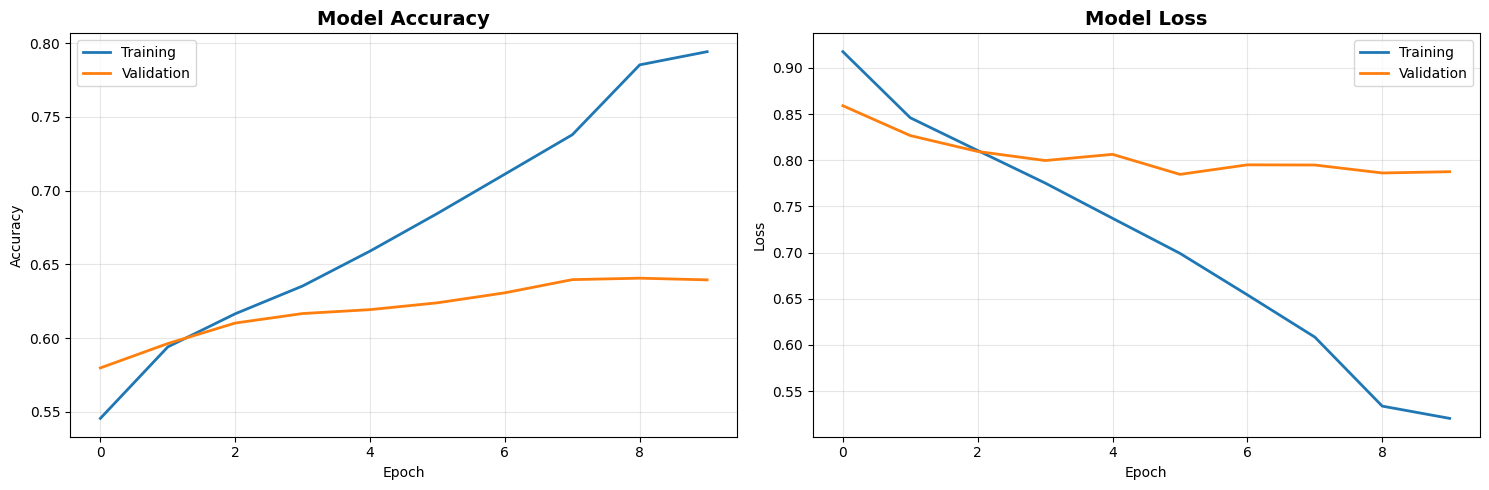

In [49]:
# Plot training history
plot_training_history(lenet_history)


Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.6853    0.5845    0.6309      1911
No Lung Opacity / Not Normal     0.5435    0.6017    0.5711      2365
                      Normal     0.6852    0.6960    0.6906      1770

                    accuracy                         0.6239      6046
                   macro avg     0.6380    0.6274    0.6309      6046
                weighted avg     0.6298    0.6239    0.6250      6046


Confusion Matrix


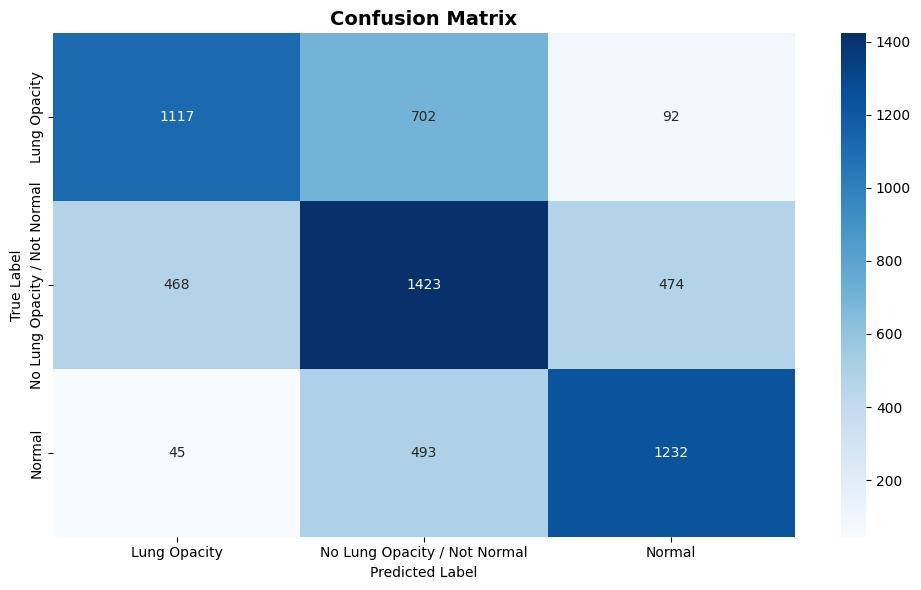

In [50]:
#Evaluating lenet model performance
evaluate_model(lenet_model, val_ds, label_encoder)

In [51]:
# Train model
deepcnn_model, deepcnn_history = train_and_evaluate('DeeperCNN', train_ds, val_ds, input_shape=(224, 224, 1), num_classes=3)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,826,051 (37.48 MB)

 Trainable params: 9,826,051 (37.48 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 855s 1s/step - accuracy: 0.4707 - loss: 0.9945 - val_accuracy: 0.5855 - val_loss: 0.9126 - learning_rate: 1.0000e-04
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - accuracy: 0.5712 - loss: 0.8827 - val_accuracy: 0.6072 - val_loss: 0.8858 - learning_rate: 1.0000e-04
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 793s 1s/step - accuracy: 0.5935 - loss: 0.8484 - val_accuracy: 0.6239 - val_loss: 0.8550 - learning_rate: 1.0000e-04
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 707s 934ms/step - accuracy: 0.6085 - loss: 0.8253 - val_accuracy: 0.6151 - val_loss: 0.8326 - learning_rate: 1.0000e-04
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 692s 914ms/step - accuracy: 0.6212 - loss: 0.8112 - val_accuracy: 0.6312 - val_loss: 0.8126 - learning_rate: 1.0000e-04
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - accuracy: 0.6276 - loss: 0.7930 - val_accuracy: 0.6194 - val_loss: 0.8246 - learning_rate: 1.0000e-04
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 731s 96

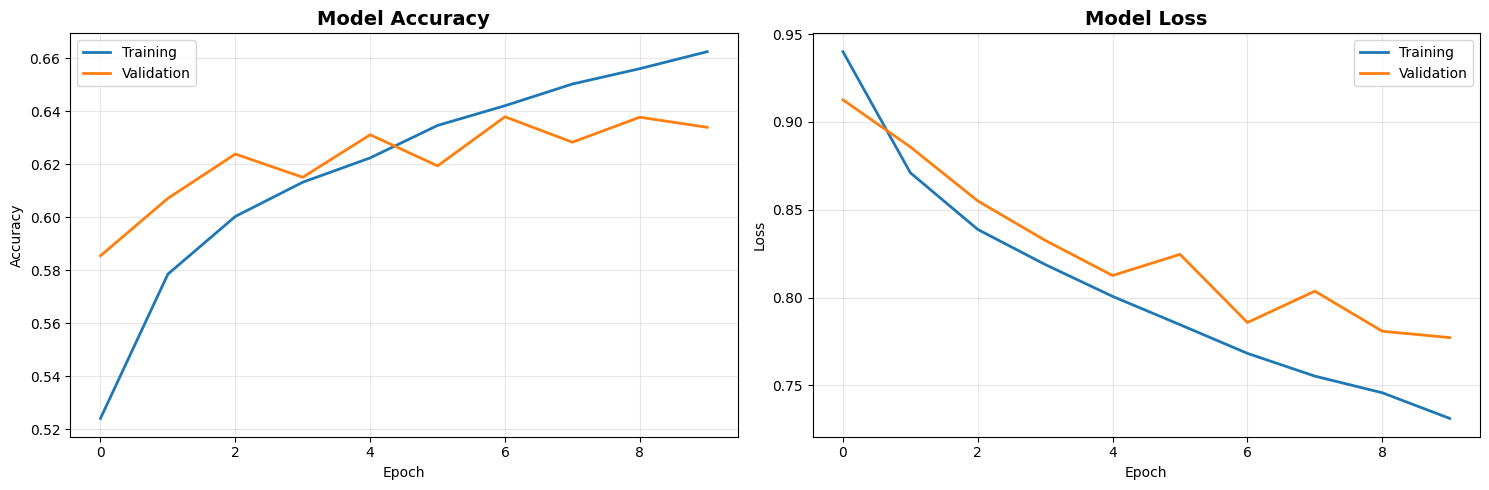

In [52]:
# Plot training history
plot_training_history(deepcnn_history)


Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.7641    0.4830    0.5919      1911
No Lung Opacity / Not Normal     0.5667    0.5966    0.5813      2365
                      Normal     0.6384    0.8469    0.7280      1770

                    accuracy                         0.6340      6046
                   macro avg     0.6564    0.6422    0.6337      6046
                weighted avg     0.6501    0.6340    0.6276      6046


Confusion Matrix


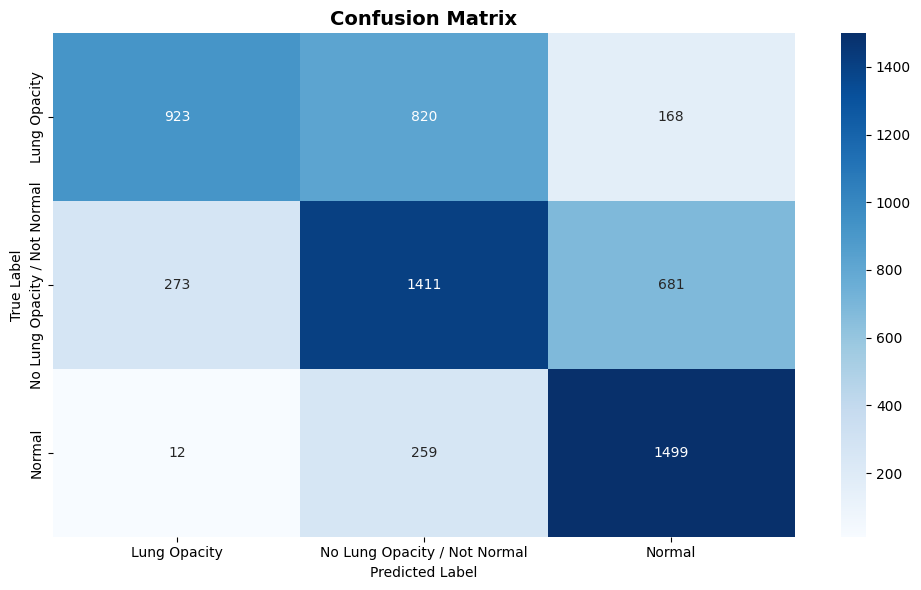

In [53]:
#Evaluating deepcnn model performance
evaluate_model(deepcnn_model, val_ds, label_encoder)

### **Observations & Insights**

#### **Basic Model**

**Observations:**

- Performance improved notably, especially in correctly classifying Lung Opacity.
- Confusion between Lung Opacity and No Lung Opacity suggests:
  - Need for clearer, more distinctive feature extraction.
  - Possible visual similarity between some X-ray images.

---

#### **MobileNet Model**

**Observations:**

- High precision on some classes (e.g., "Normal").
- Lower recall and F1-score on important classes (e.g., "Lung Opacity").
- Training loss decreases steadily, but validation loss plateaus or increases.
- Training accuracy much higher than validation accuracy.
- Evidence of overfitting and poor generalization.

---

#### **LesNet Model**

**Observations:**

- Good recall for Normal and No Lung Opacity classes.
- High precision for Lung Opacity, but recall is relatively lower.

---

#### **DeepCNN Model**

**Observations:**

- Some categories strongly outperform others.
- Distribution reveals strengths and areas needing improvement.
- Strong performers can guide focus and benchmarking.
- Weak areas require targeted training or resource allocation.
- Low correlations suggest independence.
- Useful for feature selection, avoiding multicollinearity, identifying key drivers, and risk assessment.



## **Milestone 2 - Fine Tuning & Pneumonia Detection**

### **Fine tune the trained CNN models for classification**

In [56]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert one-hot encoded labels to class indices
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [41]:
# Enhanced Model Builder Class
class EnhancedModelBuilder:
    def __init__(self, input_shape, num_classes=3):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_finetuned_cnn(self):
        return models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),
    
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.MaxPooling2D(2, 2),
    
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2, 2),
    
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
    
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])


    # Added this as part of Transfer Learning
    def build_transfer_learning_cnn(self):
        # Load the VGG16 model without the top layers
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        base_model.trainable = False  # Freeze base model

        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

In [57]:
#setup enhanced callbacks
def setup_enhanced_callbacks(model_name='enhanced_model_best'):
    """Enhanced callbacks with more monitoring"""
    return [
        callbacks.ModelCheckpoint(
            f'{model_name}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-5,
            verbose=1
        ),
        callbacks.TerminateOnNaN()
    ]

In [59]:
def load_enhanced_dataset_from_dataframe(df, img_dir, batch_size, num_classes):
    filepaths = [os.path.join(img_dir, f"{pid}.npy") for pid in df['patientId']]
    labels = df['class_encoded'].values.astype(np.int32)  # Integer labels for sparse loss

    def load_npy_and_label(path, label):
        image = tf.numpy_function(np.load, [path], tf.float32)
        image.set_shape([img_size[0], img_size[1], 1])  # Assumes grayscale
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_npy_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [60]:
# Load dataset with sample weights
train_ds = load_enhanced_dataset_from_dataframe(train_df, output_dir, batch_size, num_classes)
val_ds = load_enhanced_dataset_from_dataframe(val_df, output_dir, batch_size, num_classes)

In [63]:
def train_and_evaluate_enhanced_models(model_type, train_ds, val_ds, input_shape, num_classes, epochs=15):
    builder = EnhancedModelBuilder(input_shape, num_classes)

    if model_type == 'FineTunedCNN':
        model = builder.build_finetuned_cnn()
    elif model_type == 'TransferLearningCNN':
        model = builder.build_transfer_learning_cnn()
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Grayscale to RGB
    train_ds = train_ds.map(replicate_grayscale_channels, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(replicate_grayscale_channels, num_parallel_calls=tf.data.AUTOTUNE)

    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            F1Score(name='f1_score')
        ]
    )

    print(model.summary())

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=setup_enhanced_callbacks(model_name=f"{model_type}_best_model"),
        verbose=1
    )

    return model, history, val_ds

In [64]:
tuned_model, tuned_history, tuned_val_ds = train_and_evaluate_enhanced_models(
    model_type='FineTunedCNN',
    train_ds=train_ds,
    val_ds=val_ds,
    input_shape=(224, 224, 3),  
    num_classes=3
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

None
Epoch 1/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5149 - f1_score: 0.7906 - loss: 0.9638 - precision: 0.5613 - recall: 0.3327
Epoch 1: val_accuracy improved from -inf to 0.46295, saving model to FineTunedCNN_best_model.keras
756/756 ━━━━━━━━━━━━━━━━━━━━ 1347s 2s/step - accuracy: 0.5150 - f1_score: 0.7906 - loss: 0.9637 - precision: 0.5614 - recall: 0.3328 - val_accuracy: 0.4630 - val_f1_score: 0.8160 - val_loss: 1.0063 - val_precision: 0.4789 - val_recall: 0.4110 - learning_rate: 0.0010
Epoch 2/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5975 - f1_score: 0.8350 - loss: 0.8262 - precision: 0.6452 - recall: 0.4806
Epoch 2: val_accuracy improved from 0.46295 to 0.53573, saving model to FineTunedCNN_best_model.keras
756/756 ━━━━━━━━━━━━━━━━━━━━ 1298s 2s/step - accuracy: 0.5976 - f1_score: 0.8350 - loss: 0.8262 - precision: 0.6452 - recall: 0.4806 - val_accuracy: 0.5357 - val_f1_score: 0.8351 - val_loss: 0.9445 - val_precision: 0.5397 - val_recall: 0.5195 - 

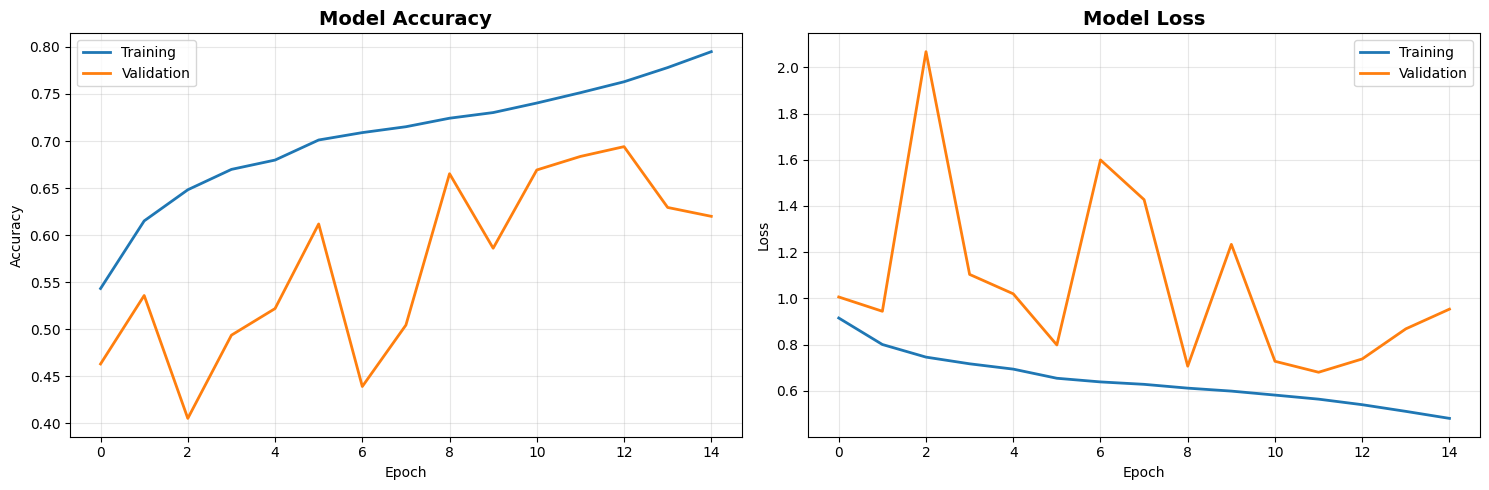

In [67]:
# Plot training history
plot_training_history(tuned_history)


Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.6807    0.6960    0.6882      1911
No Lung Opacity / Not Normal     0.6560    0.5095    0.5735      2365
                      Normal     0.7086    0.9028    0.7940      1770

                    accuracy                         0.6836      6046
                   macro avg     0.6818    0.7028    0.6853      6046
                weighted avg     0.6792    0.6836    0.6743      6046


Confusion Matrix


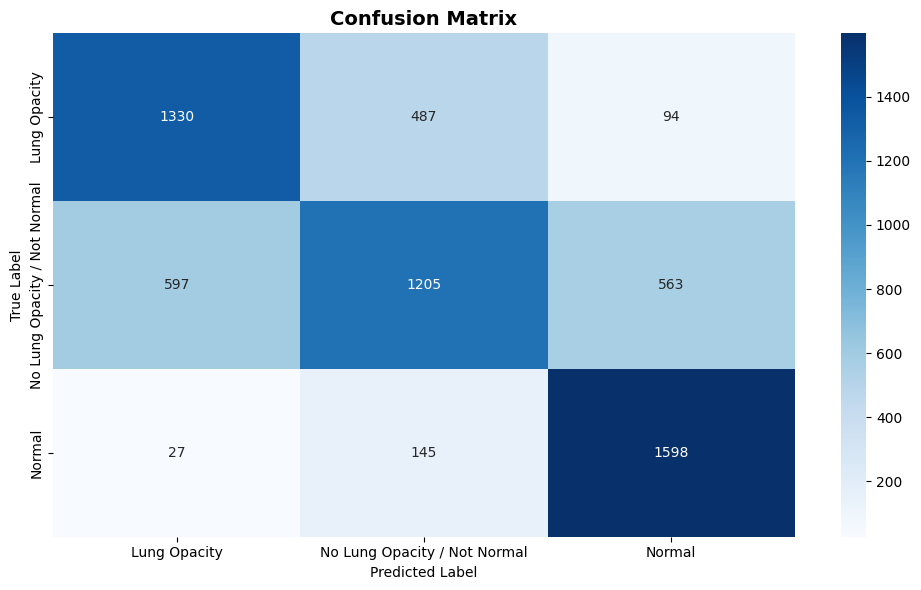

In [68]:
evaluate_model(tuned_model, tuned_val_ds, label_encoder)

### **Transfer learning model for classification**

In [ ]:
transfer_model, transfer_history, transfer_val_ds = train_and_evaluate(
    model_type='TransferLearningCNN',
    train_ds=train_ds,
    val_ds=val_ds,
    input_shape=(224, 224, 3),
    num_classes=3,
    epochs=15
)